In [1]:
import os
import pickle
import re
import random

from collections import Counter
from math import log
from operator import itemgetter

import numpy as np
try:
    from rouge import Rouge
except:
    !pip install rouge
    from rouge import Rouge

Executed in 147ms

In [2]:
random.seed(58)

Executed in 3ms

In [3]:
VECTOR_PATH = '../glove.6B.200d.pkl'
ARTICLES_PATH = '../articles/'
GOLD_SUMMARIES_PATH = '../gold_summaries/'

Executed in 3ms

In [4]:
def read_documents(doc_folder):
    """Read documents
    
    Read documents in the given `doc_folder`
    
    Parameters
    ----------
    doc_folder: str
        Document folder path
        
    Returns
    -------
    list
        Documents
    """
    article_names = os.listdir(doc_folder)
    article_names.sort()
    
    documents = []

    for article_name in article_names:
        path = os.path.join(doc_folder, article_name)
        with open(path, "rb") as f:
            try:
                doc = f.read().decode("utf-8")
            except UnicodeDecodeError as e:
                print(article_name, " has unknown encoding")
                raise e
        documents.append(doc)

    return documents

Executed in 7ms

In [5]:
def parse_document_to_sentence(doc):
    """Parse document to sentences
    
    This parser assumes every sentence begins with upper-case or digit and
    ends with ., ..., ?, ! or whitespace and after each sentence there 
    must be a whitespace.
    
    Parameters
    ----------
    doc: str
        Document string to parse
        
    Returns
    -------
    list
        Sentences
    """
    pat = re.compile(r"([A-Z0-9].*?)[\.?!\s]+\s", re.MULTILINE | re.DOTALL)
    
    return pat.findall(doc)

Executed in 4ms

In [6]:
def tokenize(doc):
    """Tokenization Function
    
    Parameters
    ----------
    doc: str
        String to tokenize
        
    Returns
    -------
    list
        List of tokens
    """
    return doc.lower().split()

Executed in 4ms

In [7]:
def parse_documents_to_sentences(documents):
    """Parse documents

    Extract sentences for given `documents`

    Parameters
    ----------
    documents: list
        List of documents

    Returns
    -------
    list
        Documents parsed to their sentences as numpy array
    """
    return [np.array(parse_document_to_sentence(doc)) for doc in documents]

Executed in 5ms

In [8]:
def tokenize_sentences(articles_as_sentences):
    """Tokenize All Articles
    
    Parameters
    ----------
    articles_as_sentences: list
        List of List of sentences
        
    Returns
    -------
    list
        List of list of tokenized sentences
    """
    
    return [[tokenize(sent) for sent in doc] for doc in articles_as_sentences]

Executed in 3ms

In [9]:
def tfidf_weights(idf_dict, tokens):
    """Compute Tf-IDF weights
    
    For given idf_dict and sentence as `token`
    calculates tf-idf scores
    
    Parameters
    ----------
    idf_dict: dict
        Dictionary of idf scores
        
    tokens: list
        List of tokens represents a sentence
        
    Returns
    -------
    dict
        Dictionary of tf-idf scores
    """
    cnt_dict = Counter(tokens)
    
    for word, cnt in cnt_dict.items():
        if word in idf_dict:
            cnt_dict[word] = cnt * idf_dict[word]
            
    return cnt_dict

Executed in 5ms

In [10]:
def sent2vec(sent, word2vec, idf_dict=None):
    """Sentence to vector
    
    Transform plain sentence to its vector representation
    
    Parameters
    ----------
    sent: str
        Sentence
    word2vec: dict
        Word vectors
    idf_dict: dict
        Pre-calculated idf scores

    Returns
    -------
    numpy.ndarray
        Vector representation of sentence
    """

    words = set(sent)
    
    if idf_dict:
        weights = tfidf_weights(idf_dict, sent)
    else:
        weights = {
            word: 1
            for word in words
        }
    
    return np.mean(
        [
            np.array(word2vec[word]) * weights[word] if word in word2vec
            else np.array(word2vec["unk"]) * weights[word]
            for word in words
        ],
        axis=0,
    )

Executed in 7ms

In [11]:
def article2sentvecs(sentences, word2vec, idf_dict=None):
    """Converts Article to Sentence Vectors
    
    Compute each sentence vector as a function of word vectors
    
    Parameters
    ----------
    sentences: list
        List of sentences of article
    
    word2vec: dict
        Word vector dictionary
    
    idf_dict: dict
        Pre-calculated idf scores
        
    Returns
    -------
    numpy.ndarray
        Article as sentence vectors
    """

    return np.array([sent2vec(sent, word2vec, idf_dict) for sent in sentences])

Executed in 4ms

In [12]:
def all_articles2sentvecs(docs_by_sentences, word2vec, idf_dicts=None):
    """Articles to sentence vectors

    Convert sentences of documents to vectors

    Parameters
    ----------
    docs_by_sentences: list
        List of list of sentences

    word2vec: dict
        Word vectors
        
    idf_dicts: list
        List of pre-calculated idf scores

    Returns
    -------
    list
        List of numpy.array, each numpy.array is document representation by its sentences
    """

    if idf_dicts:
        return [article2sentvecs(doc, word2vec, idf_dict) for doc, idf_dict in zip(docs_by_sentences, idf_dicts)]
    else:
        return [article2sentvecs(doc, word2vec) for doc in docs_by_sentences]

Executed in 5ms

In [13]:
def idf_scores(corpus):
    """Compute Idf Scores
    
    Computes IDF scores for given `corpus`
    
    Parameters
    ----------
    corpus: list
        List of documents as string
        
    Returns
    -------
    dict
        Idf scores of words
    """
    
    N = len(corpus)
    idf_dict = {}
    for doc in corpus:
        for word in set(doc):
            if word in idf_dict:
                idf_dict[word] += 1
            else:
                idf_dict[word] = 1
            
    return {
        word: log(N / df)
        for word, df in idf_dict.items()
    }

Executed in 7ms

# K-Means Clustering
## Implementation

The loss function is:

$\mathcal{L}$ = ${\left|\left| X - CM \right|\right|}_{F}$

$N$ is the number of sample, $D$ is the input dimension, $k$ is the number of clusters

$C \in \{0, 1\}^{N \times k}$, $M \in \mathbb{R}^{k \times D}$

The only constraint we have is $\sum_{i}{C_{n, i} = 1}$

\begin{align*}
    \mathcal{L}^2 &= {\left|\left| X - CM \right|\right|}_{F}^2 \\
                &= trace((X - CM)^T (X - CM)) \\
                &= trace(X^T X - X^T CM - M^T C^T X + M^T C^T C M)
\end{align*}

The partial derivative w.r.t $M$ follows

\begin{align*}
    \frac{\partial \mathcal{L}^2}{\partial M} &= \frac{\partial trace(X^T X - X^T CM - M^T C^T X + M^T C^T C M)}{\partial M} \\
                                            &= \frac{\partial trace(X^T X)}{\partial M} + \frac{\partial trace(- X^T CM)}{\partial M} + \frac{\partial trace(- M^T C^T X)}{\partial M} + \frac{\partial trace(M^T C^T C M)}{\partial M} \\
                                            &= 0 - C^T X - C^T X + 2 C^T C M \\
                                            &= -2 C^T X + 2 C^T C M
\end{align*}

And let derivative equals 0


\begin{align*}
    \frac{\partial \mathcal{L}^2}{\partial M} &= -2 C^T X + 2 C^T C M = 0 \\
    &\Rightarrow C^T C M = C^T X \\
    &\Rightarrow M = (C^T C)^{-1} C^T X
\end{align*}

Clusters have been assigned w.r.t. distance by calculated cluster means, which are rows of matrix $M$. So, for each example number $n$, corresponding value in assignment matrix is calculated as $C_{n, k} = 1$ and $C_{n, i} = 0$ for $k \neq i$, where $k = \arg\min_{k}{{\left|\left| X_{n, :} - M_{k, :} \right|\right|}_2}$. So, we can find cluster assignment in vectorized way as follows:

\begin{align*}
    \arg\min_{k}{{\left|\left| X_{n, :} - M_{k, :} \right|\right|}_2} &=  \arg\min_{k}{{\left|\left| X_{n, :} - M_{k, :} \right|\right|}_2^2}\\
                                                   &= \arg\min_{k}{\sum_{i}{(X_{n, i} - M_{k, i})^2}} \\
                                                   &= \arg\min_{k}{\sum_{i}{X_{n, i}^2 - 2 X_{n, i} M_{k, i} + M_{k, i}^2}} \\
                                                   &= \arg\min_{k}{\sum_{i}{- 2 X_{n, i} M_{k, i} + M_{k, i}^2}} \\
                                                   &= \arg\min_{k}{\sum_{i}{- 2 X_{n, i} M^T_{i, k} + M_{k, i}^2}} \\
                                                   &= \arg\min_{k}{- 2 {X M^T}_{n, k} + \sum_{i}{M_{k, i}^2}}
\end{align*}

In [14]:
def to_onehot(vec, k):
    """Convert to onehot
    
    Converts `vec` to its onehot representation
    
    Parameters
    ----------
    vec: numpy.ndarray
    
    k: int
        Size of onehot vectors
    Returns
    -------
    numpy.ndarray
        Onehot representation of given array
    """
    one_hot_mtx = np.zeros((vec.shape[0], k))
    for sample, idx in enumerate(vec):
        one_hot_mtx[sample, idx] = 1
        
    return one_hot_mtx

Executed in 5ms

In [15]:
def K_means(data, k, verbose=False):
    """K-Means clustering
    
    Given the `data` in shape (N, D) where N is the number of examples
    and D is the number of features, it calculates `k` cluster center
    that represents the data most. Maths behind this implementation is detailed
    above.
    
    Parameters
    ----------
    data: numpy.ndarray
        Data
    k: int
        Number of Clusters
    Verbose: bool
        Print loss in each iteration if True
        
    Returns
    -------
    M: numpy.ndarray
        Cluster centers
    C: numpy.ndarray
        Data assignments
    loss: float
        Last calculated loss
    """
    num_samples, input_dim = data.shape
    

    M = data[np.random.choice(num_samples, k, replace=False), :]
    C = to_onehot(np.argmin(-2 * np.dot(data, M.T) + np.power(M, 2).sum(axis=1)[np.newaxis, :], axis=1), k)
    prev_C = np.zeros_like(C)
    
    loss = np.linalg.norm(data - np.dot(C, M), ord="fro")
    
    while not np.all(C == prev_C):
        if verbose:
            print("Loss: {}".format(loss))
        prev_C = C
        
        M = np.dot(np.dot(np.linalg.pinv(np.dot(C.T, C)), C.T), data)
        C = to_onehot(np.argmin(-2 * np.dot(data, M.T) + np.power(M, 2).sum(axis=1)[np.newaxis, :], axis=1), k)

        loss = np.linalg.norm(data - np.dot(C, M), ord="fro")
        
    return M, C, loss

Eexecuted in 13ms

## Testing K-Means

In this part, I have created fake dataset and tested my implementation of k-means clustering algorithm with the fake dataset

In [16]:
import matplotlib.pyplot as plt

Executed in 284ms

In [17]:
# 3 Different centers
data1 = np.random.rand(50, 2) * 3 + 5
data2 = np.random.rand(30, 2) * 3
data3 = np.random.rand(40, 2) * 3 + 10

data = np.concatenate([data1, data2, data3])

Executed in 5ms

### Plot dataset

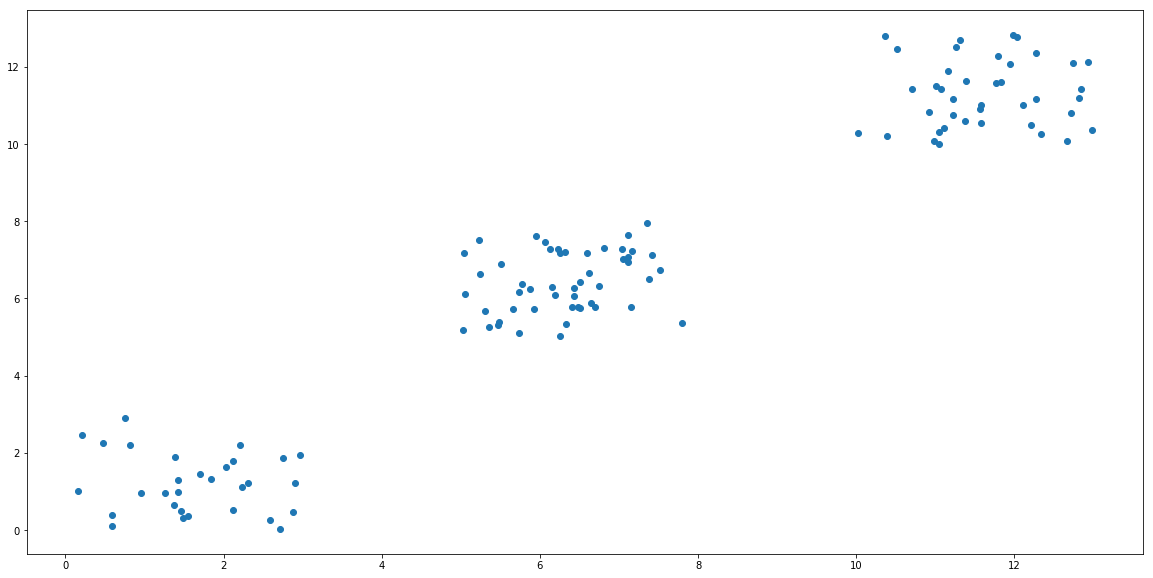

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(data[:, 0], data[:, 1], "o")

Executed in 317ms

### Plot dataset with cluster centers

M, C, loss = K_means(data, 3)
plt.figure(figsize=(20, 10))
plt.plot(data[:, 0], data[:, 1], "o")
plt.plot(M[:, 0], M[:, 1], "rx")

Executed in 301ms

# Clustering and Finding Most Representative Sentences

## Find Most Representative Sentences for Given Cluster Centers

In [20]:
def find_most_repr_sent_in_cluster(data, M):
    """Find Most Representative Sentences
    
    Parameters
    ----------
    data: numpy.ndarray
        Document representation
        
    M: numpy.ndarray
        Cluster centers
        
    Returns
    -------
    numpy.ndarray
        Indices of sentences which are most representative ones
    """
    return np.argmin(-2 * np.dot(data, M.T) + np.power(M, 2).sum(axis=1)[np.newaxis, :], axis=0)

Executed in 7ms

## Find Cluster Centers and Most Representative Sentences

In [21]:
def cluster(doc_vectors, num_k_means_trial, k_formula):
    """Cluster and return most represntative sentence indices
    
    Parameters
    ----------
    doc_vectors: numpy.ndarray
        Document representation by sentence vectors
        
    num_k_means_trial: int
        Number of k-means trial select best one
        
    Returns
    -------
    numpy.ndarray
        List of most representative indices
    """
    k = max(1, int(k_formula(len(doc_vectors))))

    k_means = []
    min_loss_model = -1
    min_loss = float("inf")

    for i in range(num_k_means_trial):
        M, C, loss = K_means(doc_vectors, k)
        if loss < min_loss:
            min_loss = loss
            min_loss_model = i
            
        k_means.append(M)
        
    best_means = k_means[min_loss_model]
    repr_sentences = find_most_repr_sent_in_cluster(doc_vectors, best_means)

    return repr_sentences

Executed in 10ms

# Extract Summary

In [22]:
def extract_summary(doc_vectors, doc_sentences, k_means_trial=5, k_formula=lambda n: n * 0.5):
    """Extracts Summary
    
    Parameters
    ----------
    doc_vectors: numpy.ndarray
        Document representation by sentence vectors
    doc_sentences: numpy.ndarray
        Document representation by its sentences
        
    Returns
    -------
    str
        Summary of document
    """
    most_repr_sentences = cluster(doc_vectors, k_means_trial, k_formula)
    return ". ".join(list(set(doc_sentences[most_repr_sentences])))

Executed in 7ms

# Evaluation

In [23]:
def evaluation(gold_summaries, extracted_summaries):
    """Evaluation of summaries
    
    Parameters
    ----------
    gold_summaries: list
        Reference summaries
    extracted_summaries: list
        Extracted summaries by the model
        
    Returns
    -------
    list
        Rough scores as tuple (rouge-1.f, rouge-2.f, rouge-l.f)
    """
    rouge = Rouge()
    rouge_scores = []
    for hyp, ref in zip(gold_summaries, extracted_summaries):
        scores = rouge.get_scores(hyp, ref)[0]
        rouge_scores.append((scores["rouge-1"]["f"], scores["rouge-2"]["f"], scores["rouge-l"]["f"]))
    return rouge_scores

Executed in 8ms

# Model Construction

## Data Manipulation

### Split Train and Test

In [24]:
def split_train_test(articles, gold_summaries, test_ratio=0.1):
    """Split Train and Test Data
    
    Parameters
    ----------
    articles: list
        List of input articles
    gold_summaries: list
        List of label gold summaries
    test_ratio: float
        Test set ratio
        
    Returns
    -------
    tuple
        Train input
    tuple
        Train label
    tuple
        Test input
    tuple
        Test label
    """
    assert len(articles) == len(gold_summaries)
    num_examples = len(articles)
    indices = list(range(num_examples))
    random.shuffle(indices)
    num_train_example = int((1 - test_ratio) * num_examples)
    test_indices = indices[num_train_example:]
    train_indices = indices[:num_train_example]
    train_getter = itemgetter(*train_indices)
    test_getter = itemgetter(*test_indices)

    return train_getter(articles), train_getter(gold_summaries), test_getter(articles), test_getter(gold_summaries)

Executed in 9ms

### Split Data Into K-Folds

In [36]:
def kfolds(x, y, k=5):
    """K-Fold Cross Validation
    
    Parameters
    ----------
    x: list
        Input data
    y: list
        Output data
    k: int
        Number of folds
        
    Yields
    ------
    tuple
        Train input for fold i
    tuple
        Train output for fold i
    tuple
        Validation input for fold i
    tuple
        Validation output for fold i
    """
    assert len(x) == len(y)
    
    num_samples = len(x)
    indices = list(range(num_samples))
    random.shuffle(indices)
    fold_size = num_samples // k
    
    for i in range(0, num_samples, fold_size):
        valid_indices = indices[i: i + fold_size]
        train_indices = indices[:i] + indices[i + fold_size:]
        valid_getter = itemgetter(*valid_indices)
        train_getter = itemgetter(*train_indices)
        
        yield train_getter(x), train_getter(y), valid_getter(x), valid_getter(y)

Executed in 12ms

## Get Scores for given dataset

In [26]:
def get_r_scores(articles, gold_summaries, use_tfidf, k_means_trial, k_formula):
    """Get Rouge Scores
    
    Extracts summaries and computes rouge scores for given `articles` and `gold_summaries`
    
    Parameters
    ----------
    articles: list
        List of articles to extract summaries
    
    gold_summaries: list
        List of gold summaries
    
    use_tfidf: bool
        If true calculate and use tf-idf scores
    
    k_means_trial: int
        Number of trials for k-means algorithm

    k_formula: function
        Rule for k in k-means algorithm
        
    """
    sentences = parse_documents_to_sentences(articles)
    tokens = tokenize_sentences(sentences)

    if use_tfidf:
        idf_dicts = [idf_scores(docs) for docs in tokens]
    else:
        idf_dicts = None

    doc_vectors = all_articles2sentvecs(tokens, word_vectors, idf_dicts)

    summaries = [
        extract_summary(doc_vector, doc_sentences, k_means_trial, k_formula)
        for doc_vector, doc_sentences in zip(doc_vectors, sentences)
    ]
    r_scores = evaluation(gold_summaries, summaries)
    r_scores_avg = np.array(r_scores).mean(axis=0)

    return r_scores_avg


Executed in 10ms

## Validate and Report Given Train and Test Sets

In [27]:
def validate_and_report(train_articles, train_gold_summaries,
                        test_articles, test_gold_summaries,
                        k,
                        use_tfidf,
                        k_means_trial,
                        k_formula):
    
    """Compute Validation Scores and Test Score
    
    Parameters
    ----------
    train_articles: list
        Train input set

    train_gold_summaries: list
        Train label set
    
    test_articles: list
        Test input set
    
    test_gold_summaries: list
        Test label set

    k: int
        k parameter for k-folds validation
    
    use_tfidf: bool
        If true calculate and use tf-idf scores

    k_means_trial: int
        Number of trials for k-means algorithm

    k_formula: function
        Rule for k in k-means algorithm
    """

    r1 = []
    r2 = []
    rL = []
    for t_articles, t_gold_summaries, v_articles, v_gold_summaries in kfolds(train_articles, train_gold_summaries, k=k):
        r1_, r2_, rL_ = get_r_scores(
            v_articles,
            v_gold_summaries,
            use_tfidf=use_tfidf,
            k_means_trial=k_means_trial,
            k_formula=k_formula)
        r1.append(r1_)
        r2.append(r2_)
        rL.append(rL_)

    def get_statistics(r):
        return np.mean(r), np.std(r)

    mean_r1, std_r1 = get_statistics(r1)
    mean_r2, std_r2 = get_statistics(r2)
    mean_rL, std_rL = get_statistics(rL)

    def report(name, mean, std):
        print("{}: {} +/- {}".format(name, mean, std))

    print("Validation Scores")
    print("-----------------")
    report("Rouge 1", mean_r1, std_r1)
    report("Rouge 2", mean_r2, std_r2)
    report("Rouge L", mean_rL, std_rL)

    r1_t, r2_t, rL_t = get_r_scores(
        test_articles,
        test_gold_summaries,
        use_tfidf=use_tfidf,
        k_means_trial=k_means_trial,
        k_formula=k_formula
    )

    print("Test Scores")
    print("-----------")
    print("Rouge 1: {}".format(r1_t))
    print("Rouge 2: {}".format(r2_t))
    print("Rouge L: {}".format(rL_t))
    
    return r1, r2, rL, r1_t, r2_t, rL_t

Executed in 17ms

## Loading Word Vectors

In [28]:
with open(VECTOR_PATH, "rb") as f:
    word_vectors = pickle.load(f)

Executed in 12.4s

## Load Dataset

In [29]:
articles = read_documents(ARTICLES_PATH)
gold_summaries = read_documents(GOLD_SUMMARIES_PATH)

Executed in 1.41s

In [30]:
train_articles, train_gold_summaries, test_articles, test_gold_summaries = split_train_test(articles, gold_summaries, test_ratio=0.1)

Executed in 6ms

# Models

## Model 1

-  TF-IDF Weighted with $k = N * 0.5$ where k is parameter for k-Means and N is the number of documents

In [31]:
use_tfidf = True
k_formula = lambda n: n * 0.5
k_means_trial = 5
k = 5

_ = validate_and_report(train_articles, train_gold_summaries, test_articles, test_gold_summaries, k, use_tfidf, k_means_trial, k_formula)

Validation Scores
-----------------
Rouge 1: 0.31138632803581406 +/- 0.008409944531503212
Rouge 2: 0.1604115598828965 +/- 0.01045854523227885
Rouge L: 0.26463736436639174 +/- 0.015118714987182633
Test Scores
-----------
Rouge 1: 0.31287251313868963
Rouge 2: 0.1731771597230251
Rouge L: 0.26280171556918674


Executed in 59.0s

## Model 2

-  TF-IDF Weighted with $k = N^{0.5}$ where k is parameter for k-Means and N is the number of documents

In [32]:
use_tfidf = True
k_formula = lambda n: n ** 0.5
k_means_trial = 5
k = 5

_ = validate_and_report(train_articles, train_gold_summaries, test_articles, test_gold_summaries, k, use_tfidf, k_means_trial, k_formula)

Validation Scores
-----------------
Rouge 1: 0.23605103549710538 +/- 0.007454600554395281
Rouge 2: 0.12299713742248027 +/- 0.017593427979157708
Rouge L: 0.17952855221891295 +/- 0.018400090863576014
Test Scores
-----------
Rouge 1: 0.24349030144599607
Rouge 2: 0.1270980441100667
Rouge L: 0.18048513703694674


Executed in 42.4s

## Model 3
-  Simple averaged word vectors with $k = N * 0.5$ where k is parameter for k-Means and N is the number of documents

In [33]:
use_tfidf = False
k_formula = lambda n: n * 0.5
k_means_trial = 5
k = 5

_ = validate_and_report(train_articles, train_gold_summaries, test_articles, test_gold_summaries, k, use_tfidf, k_means_trial, k_formula)

Validation Scores
-----------------
Rouge 1: 0.34620566126789276 +/- 0.035084481768938684
Rouge 2: 0.20002448159387484 +/- 0.024387943041996128
Rouge L: 0.2803608290502537 +/- 0.041006477820275125
Test Scores
-----------
Rouge 1: 0.3310038295681289
Rouge 2: 0.18764942906671997
Rouge L: 0.2602977812079017


Executed in 51.0s

## Model 4
-  Simple averaged word vectors with $k = N^{0.5}$ where k is parameter for k-Means and N is the number of documents

In [34]:
use_tfidf = False
k_formula = lambda n: n ** 0.5
k_means_trial = 5
k = 5

_ = validate_and_report(train_articles, train_gold_summaries, test_articles, test_gold_summaries, k, use_tfidf, k_means_trial, k_formula)

Validation Scores
-----------------
Rouge 1: 0.28457624432831957 +/- 0.07984627680727928
Rouge 2: 0.17239069522857373 +/- 0.0889327792082479
Rouge L: 0.1981388762654932 +/- 0.0573083952475998
Test Scores
-----------
Rouge 1: 0.2538088856431573
Rouge 2: 0.1317802279682391
Rouge L: 0.1744392999660256


Executed in 38.3s

# Results Table

|Model                           | Metric        |         Validation Score| Test Score |
| ------------------------------ |:-------------:| -----------------------:| ---------: | 
| Model 1 (tf-idf, $k = N * 0.5$)|     Rouge - 1 |      0.31138632803581406 +/- 0.008409944531503212|      0.31287251313868963|
| Model 1 (tf-idf, $k = N * 0.5$)|     Rouge - 2 |      0.1604115598828965 +/- 0.01045854523227885|      0.1731771597230251|
| Model 1 (tf-idf, $k = N * 0.5$)|     Rouge - L |      0.26463736436639174 +/- 0.015118714987182633|      0.1744392999660256|
| Model 2 (tf-idf, $k = N^{0.5}$)|     Rouge - 1 |      0.23605103549710538 +/- 0.007454600554395281|      0.24349030144599607|
| Model 2 (tf-idf, $k = N^{0.5}$)|     Rouge - 2 |      0.12299713742248027 +/- 0.017593427979157708|      0.1270980441100667|
| Model 2 (tf-idf, $k = N^{0.5}$)|     Rouge - L |      0.17952855221891295 +/- 0.018400090863576014|      0.18048513703694674|
| Model 3 (simple, $k = N * 0.5$)|     Rouge - 1 |      0.34620566126789276 +/- 0.035084481768938684|      0.3310038295681289|
| Model 3 (simple, $k = N * 0.5$)|     Rouge - 2 |      0.20002448159387484 +/- 0.024387943041996128|      0.18764942906671997|
| Model 3 (simple, $k = N * 0.5$)|     Rouge - L |      0.2803608290502537 +/- 0.041006477820275125|      0.2602977812079017|
| Model 4 (simple, $k = N^{0.5}$)|     Rouge - 1 |      0.28457624432831957 +/- 0.07984627680727928|0.2538088856431573|
| Model 4 (simple, $k = N^{0.5}$)|     Rouge - 2 |      0.17239069522857373 +/- 0.0889327792082479|      0.1317802279682391|
| Model 4 (simple, $k = N^{0.5}$)|     Rouge - L |      0.1981388762654932 +/- 0.0573083952475998|      0.1744392999660256|